# Analysis Notebook - Count Genes - `CountGenes`

As instructed by the software, we are using the raw counts as provided by rMATS.  The raw counts we are using in the model are `ijc` and `sjc`, the sample specific raw read counts as they align to the junctions of the `included exon (ijc)` and the junctions of the `excluded or skipped exon (sjc)` respectively.


Be sure to set your GITHUB_TOKEN, prior to downloading files

One suggestion is change it to your token and then run it then immediately change it back to this:

Sys.setenv(GITHUB_TOKEN = "your-very-own-github-token")

In [ ]:
# Sys.setenv(GITHUB_TOKEN="your-very-own-github-token")

In [1]:
library(dplyr)
library(ggplot2)
library(limma)
library(piggyback)
library(multtest)
library(Biobase)
library(edgeR)
library(tibble)
#install.packages('R.utils')
library(R.utils)

Warning message:
“package ‘dplyr’ was built under R version 3.6.2”
Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following object is masked from ‘package:limma’:

    plotMA

The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.cal

## Download all the rMATS results

Each of the alternative splicing output files are downloaded here:

In [2]:
#
# refined results (FC > 1.5 and pVal < 0.05)
# for the sex*as_event coefficient result for the linear model
#
significant_results_dir = "../data/"
pattern = "DGE_sex_as_events_refined.csv"
files <- list.files(path = significant_results_dir, pattern = pattern)
as_types <- c("a3ss", "a5ss", "mxe", "ri", "se")

In [4]:
a3ss_annot <- read.table(file = "../data/fromGTF.A3SS.txt", sep = "\t", quote = "\"", header = T, stringsAsFactors = F)
a5ss_annot <- read.table(file = "../data/fromGTF.A5SS.txt", sep = "\t", quote = "\"", header = T, stringsAsFactors = F)
mxe_annot <- read.table(file = "../data/fromGTF.MXE.txt", sep = "\t", quote = "\"", header = T, stringsAsFactors = F)
ri_annot <- read.table(file = "../data/fromGTF.RI.txt", sep = "\t", quote = "\"", header = T, stringsAsFactors = F)
se_annot <- read.table(file = "../data/fromGTF.SE.txt", sep = "\t", quote = "\"", header = T, stringsAsFactors = F)

In [6]:
message ("\nReading significant events for each splicing factor\n")
gene_as = data.frame()
for (i in 1:length(files)) {
    lines <- read.csv(paste0(significant_results_dir, files[i]),header = TRUE)
    event     <- as.vector(as.character(rownames(lines)))
    tissue <- gsub("_DGE_sex_as_events_refined.csv","", files[i], fixed = TRUE)
    
    if (dim(lines)[1] > 0) { #has significant events
        # rownames of the significant results file are a combination of gene-symbol and junction name
        # using a regular expression - extract the last numbers that then are the index to the annotation table
        event_idx <- substring(event, regexpr("[0-9]+$", event))
        
        if (grepl("a3ss_", files[i])) {
            tissue <- gsub("a3ss_","", tissue, fixed = TRUE)
            idx <- match(event_idx, a3ss_annot$ID)
            res <- data.frame(Tissue = tissue, ASE = "A3SS", 
                              GeneSymbol = a3ss_annot$geneSymbol[idx],
                              chr = a3ss_annot$chr[idx])
        }
        if (grepl("a5ss_", files[i])) {
            tissue <- gsub("a5ss_","", tissue, fixed = TRUE)
            idx <- match(event_idx, a5ss_annot$ID)
            res <- data.frame(Tissue = tissue, ASE = "A5SS", 
                              GeneSymbol = a5ss_annot$geneSymbol[idx],
                              chr = a5ss_annot$chr[idx])
        }
        if (grepl("mxe_", files[i])) {
            tissue <- gsub("mxe_","", tissue, fixed = TRUE)
            idx <- match(event_idx, a3ss_annot$ID)
            res <- data.frame(Tissue = tissue, ASE = "MXE", 
                              GeneSymbol = mxe_annot$geneSymbol[idx],
                              chr = mxe_annot$chr[idx])
        }
        if (grepl("se_", files[i])) {
            idx <- match(event_idx, se_annot$ID)
            res <- data.frame(Tissue = tissue, ASE = "SE", 
                              GeneSymbol = se_annot$geneSymbol[idx],
                              chr = se_annot$chr[idx])
            tissue <- gsub("se_","", tissue, fixed = TRUE)
        }
        if (grepl("ri_", files[i])){
            tissue <- gsub("ri_","", tissue, fixed = TRUE)
            idx <- match(event_idx, ri_annot$ID)
            res <- data.frame(Tissue = tissue, ASE = "RI", 
                              GeneSymbol = ri_annot$geneSymbol[idx],
                              chr = a3ss_annot$chr[idx])
        }
        gene_as <- rbind(gene_as, res)
        
    } #if has sig. events
    
} #for all files    
message ("\nDone reading significant events!\n")


Reading significant events for each splicing factor


Done reading significant events!



In [10]:
head(gene_as)
tail(gene_as)
dim(gene_as)

,Tissue,ASE,GeneSymbol,chr
,<fct>,<fct>,<fct>,<fct>
1,adipose_subcutaneous,SE,DLEU1,chr13
2,adipose_subcutaneous,SE,DLEU1,chr13
3,adipose_subcutaneous,SE,AKT1,chr14
4,adipose_subcutaneous,SE,MLF1,chr3
5,adipose_visceral_omentum,SE,DLEU1,chr13
6,adipose_visceral_omentum,SE,DLEU1,chr13


,Tissue,ASE,GeneSymbol,chr
,<fct>,<fct>,<fct>,<fct>
7072,se_whole_blood,SE,XIST,chrX
7073,se_whole_blood,SE,KDM5C,chrX
7074,se_whole_blood,SE,ZFX,chrX
7075,se_whole_blood,SE,ZFX,chrX
7076,se_whole_blood,SE,KDM6A,chrX
7077,se_whole_blood,SE,MMEL1,chr1


[1] 7077    4

In [12]:
# Count most frequent spliced genes
res <- gene_as %>% group_by(GeneSymbol) %>% count(GeneSymbol) %>% arrange(desc(n)) %>% as.data.frame()
res$GeneSymbol <- factor(res$GeneSymbol, levels = res$GeneSymbol)
length(res$GeneSymbol)

[1] 3231

In [13]:
#Add number of tissues
nTissues <- rep(NA, length(res))
for (i in 1:nrow(res)) {
  df_gene <- gene_as %>% filter(GeneSymbol == res$GeneSymbol[i])
  nTissues[i] <- length(unique(df_gene$Tissue))
}
res$Tissues <- nTissues

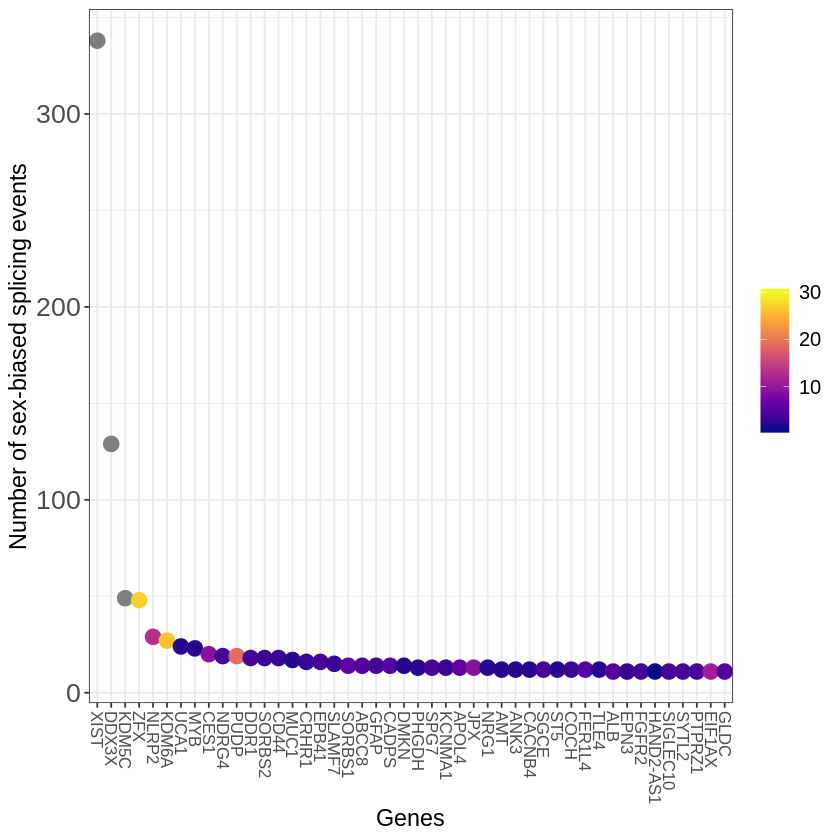

In [14]:
# Genes with more than 10 splicing events
ggplot(res[res$n > 10, ], aes(x = GeneSymbol, y = n)) +
  geom_point(size = 4, aes(fill = Tissues, color = Tissues)) +
  theme_bw() +
  theme(axis.text.x = element_text(size=10, angle = 270, hjust = 0.0, vjust = 0.5),
        axis.text.y = element_text(size=16),
        axis.title.x = element_text(face="plain", colour="black", 
                                    size=14),
        axis.title.y = element_text(face="plain", colour="black", 
                                    size=14),
        legend.title=element_blank(),
        legend.text = element_text(face="plain", colour="black", 
                                   size=12)) +
  scale_fill_viridis_c(aesthetics = c("colour", "fill"),
                       option = "plasma",
                       limits = c(1, 30), breaks = c(10, 20, 30)) +
  ylab(paste("Number of sex-biased splicing events")) +
  xlab("Genes")

Pie chart

Tissue specific 1 tissue
Tissue group 2-5 tissues
Recurrent > 5 tissues

In [15]:
#Pie chart - Number of patients with 0, 1, >1 events
counts <- c(res %>% filter(Tissues == 1) %>% count() %>% as.numeric(),
            res %>% filter(Tissues > 1 & Tissues < 5) %>% count() %>% as.numeric(),
            res %>% filter(Tissues > 5) %>% count() %>% as.numeric())

In [16]:
# Define some colors ideal for black & white print
colors <- c("white","grey70","grey90","grey50","black")
colors <- c("grey90","grey50", "black")

Calculate the percentage for each category

In [17]:
counts_labels <- round(counts/sum(counts) * 100, 1)
counts_labels <- paste(counts_labels, "%", sep="")
counts_labels <- paste(counts_labels, counts, sep =" ")

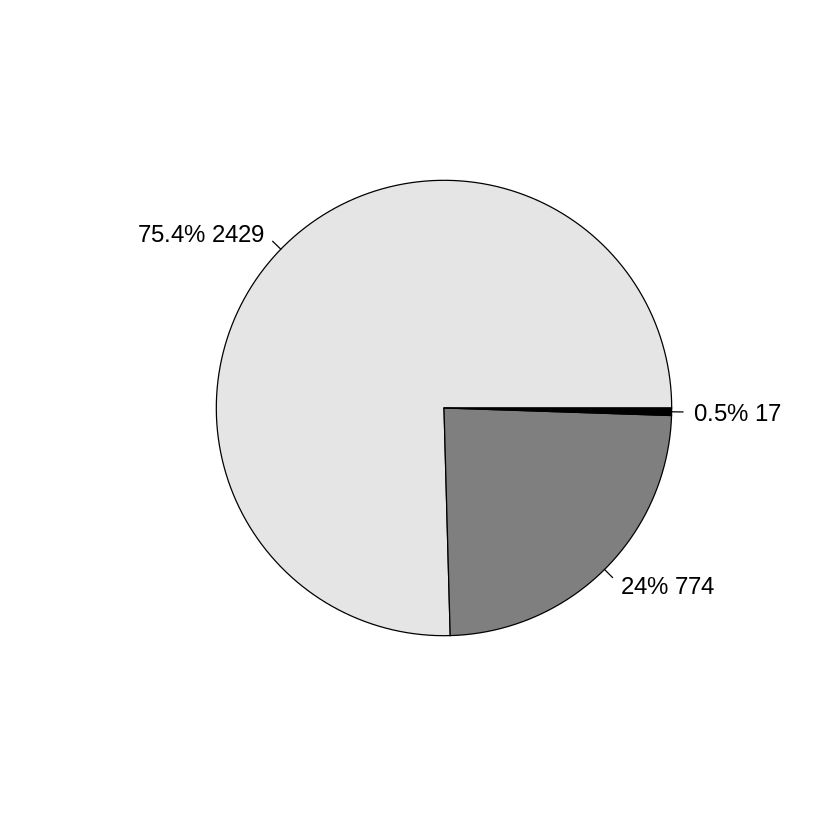

In [42]:
# Create a pie chart with defined heading and custom colors
# and labels
pie(counts, main="", col=colors, labels=counts_labels,
    cex=1.2)
# Create a legend at the right   
legend(1.5, 0.5, c("1 tissue","2-5 tissues","> 5 tissues"), cex=1.2, 
       fill=colors)

In [25]:
getwd()
setwd("../data")
getwd()
system("wget ftp://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_30/gencode.v30.annotation.gtf.gz")
system("gunzip gencode.v30.annotation.gtf.gz")
getwd()
setwd("../jupyter")
getwd()

[1] "/mnt/shared/gcp-user/session_data/sbas/jupyter"

[1] "/mnt/shared/gcp-user/session_data/sbas/data"

[1] "/mnt/shared/gcp-user/session_data/sbas/data"

[1] "/mnt/shared/gcp-user/session_data/sbas/jupyter"

In [26]:
# Number of splicing events normalized per chromosome
library(rtracklayer)

gencode <- import.gff("../data/gencode.v30.annotation.gtf")

In [27]:
exons <- gencode[ gencode$type == "exon", ]
exons <- as.data.frame(exons)

In [28]:
all_chr <- as.character(unique(gene_as$chr))
chr_counts <- rep(0, length(all_chr))

In [29]:
for (i in 1:length(all_chr)) {
  chr_counts[i] <- nrow(exons[exons$seqnames == all_chr[i], ])
}

In [30]:
exon_counts <- data.frame(chr = all_chr, counts = chr_counts)

In [31]:
# Count most frequent spliced chromosomes
res <- gene_as %>% group_by(chr) %>% count(chr) %>% arrange(desc(n)) %>% as.data.frame()
res$chr <- factor(res$chr, levels = res$chr)

In [32]:
idx <- match(res$chr, exon_counts$chr)

In [33]:
res$ExonCounts <- exon_counts$counts[idx]

In [34]:
res$Index <- (res$n / res$ExonCounts) * 1000

In [35]:
res_sorted <- res %>% arrange(desc(Index))
res_sorted$chr <- factor(res_sorted$chr, levels = res_sorted$chr)

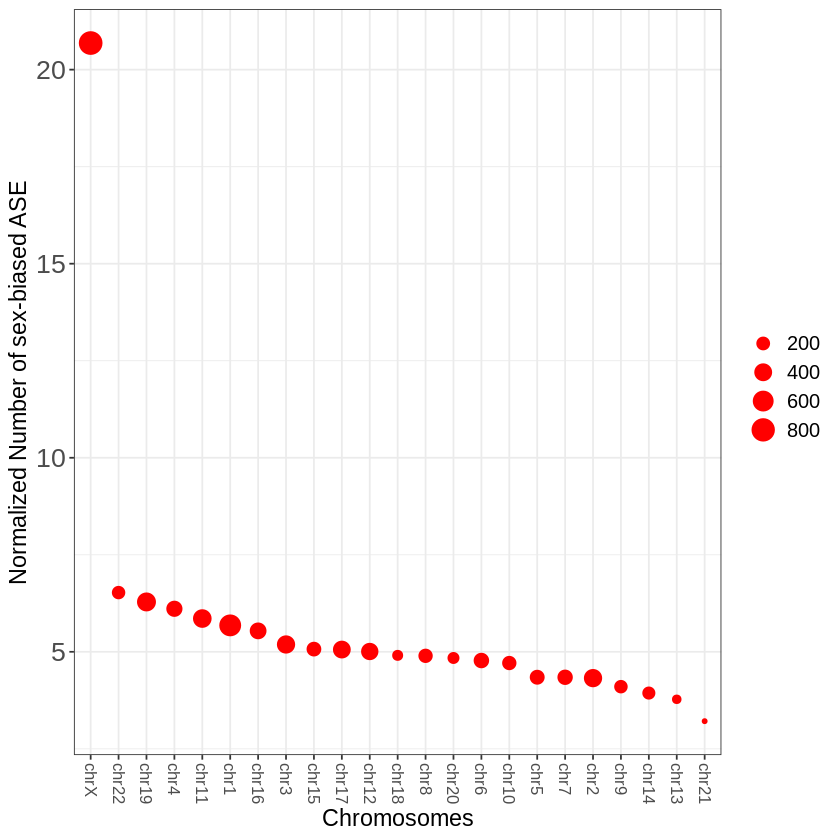

In [36]:
ggplot(res_sorted, aes(x = chr, y = Index, size = n)) +
  geom_point(color = "red") +
  theme_bw() +
  theme(axis.text.x = element_text(size=10, angle = 270, hjust = 0.0, vjust = 0.5),
        axis.text.y = element_text(size=16),
        axis.title.x = element_text(face="plain", colour="black", 
                                    size=14),
        axis.title.y = element_text(face="plain", colour="black", 
                                    size=14),
        legend.title=element_blank(),
        legend.text = element_text(face="plain", colour="black", 
                                   size=12)) +
  scale_fill_viridis_c(aesthetics = c("colour", "fill"),
                       option = "plasma",
                       limits = c(1, 650)) +
  ylab(paste("Normalized Number of sex-biased ASE")) +
  xlab("Chromosomes") +
  guides(size = guide_legend(title = "Number of ASE"))

In [38]:
write.table(res_sorted, file = "../data/SplicingIndex_chr.tsv", sep = "\t", quote = F,
            row.names = F)

## Metadata

For replicability and reproducibility purposes, we also print the following metadata:

1. Checksums of **'artefacts'**, files generated during the analysis and stored in the folder directory **`data`**
2. List of environment metadata, dependencies, versions of libraries using `utils::sessionInfo()` and [`devtools::session_info()`](https://devtools.r-lib.org/reference/session_info.html)

### 1. Checksums with the sha256 algorithm

In [39]:
rm (notebookid)
notebookid   = "countGenes"
notebookid

message("Generating sha256 checksums of the file `../data/SplicingIndex_chr.tsv` directory .. ")
system(paste0("cd ../data && find . -name SplicingIndex_chr.tsv -exec sha256sum {} \\;  >  ../metadata/", notebookid, "_sha256sums.txt"), intern = TRUE)
message("Done!\n")

paste0("../metadata/", notebookid, "_sha256sums.txt")

data.table::fread(paste0("../metadata/", notebookid, "_sha256sums.txt"), header = FALSE, col.names = c("sha256sum", "file"))

Warning message in rm(notebookid):
“object 'notebookid' not found”

[1] "countGenes"

Generating sha256 checksums of the file `../data/SplicingIndex_chr.tsv` directory .. 


character(0)

Done!



[1] "../metadata/countGenes_sha256sums.txt"

sha256sum,file
<chr>,<chr>
02a4693f9fccc6d7dd8dd27fd72500c5cea03b7b442e36f830295247d3a9949d,./SplicingIndex_chr.tsv


### 2. Libraries metadata

In [44]:
dev_session_info   <- devtools::session_info()
utils_session_info <- utils::sessionInfo()

message("Saving `devtools::session_info()` objects in ../metadata/devtools_session_info.rds  ..")
saveRDS(dev_session_info, file = paste0("../metadata/", notebookid, "_devtools_session_info.rds"))
message("Done!\n")

message("Saving `utils::sessionInfo()` objects in ../metadata/utils_session_info.rds  ..")
saveRDS(utils_session_info, file = paste0("../metadata/", notebookid ,"_utils_info.rds"))
message("Done!\n")

dev_session_info$platform
dev_session_info$packages[dev_session_info$packages$attached==TRUE, ]

Saving `devtools::session_info()` objects in ../metadata/devtools_session_info.rds  ..
Done!

Saving `utils::sessionInfo()` objects in ../metadata/utils_session_info.rds  ..
Done!



 setting  value                       
 version  R version 3.6.1 (2019-07-05)
 os       Ubuntu 18.04.3 LTS          
 system   x86_64, linux-gnu           
 ui       X11                         
 language en_US.UTF-8                 
 collate  en_US.UTF-8                 
 ctype    en_US.UTF-8                 
 tz       Etc/UTC                     
 date     2020-05-27                  

,package,ondiskversion,loadedversion,path,loadedpath,attached,is_base,date,source,md5ok,library
,<chr>,<chr>,<chr>,<chr>,<chr>,<lgl>,<lgl>,<chr>,<chr>,<lgl>,<fct>
Biobase,Biobase,2.46.0,2.46.0,/opt/conda/lib/R/library/Biobase,/opt/conda/lib/R/library/Biobase,TRUE,FALSE,2019-10-29,Bioconductor,NA,/opt/conda/lib/R/library
BiocGenerics,BiocGenerics,0.32.0,0.32.0,/opt/conda/lib/R/library/BiocGenerics,/opt/conda/lib/R/library/BiocGenerics,TRUE,FALSE,2019-10-29,Bioconductor,NA,/opt/conda/lib/R/library
dplyr,dplyr,0.8.4,0.8.4,/opt/conda/lib/R/library/dplyr,/opt/conda/lib/R/library/dplyr,TRUE,FALSE,2020-01-31,CRAN (R 3.6.2),NA,/opt/conda/lib/R/library
edgeR,edgeR,3.28.1,3.28.1,/opt/conda/lib/R/library/edgeR,/opt/conda/lib/R/library/edgeR,TRUE,FALSE,2020-02-26,Bioconductor,NA,/opt/conda/lib/R/library
GenomeInfoDb,GenomeInfoDb,1.22.1,1.22.1,/opt/conda/lib/R/library/GenomeInfoDb,/opt/conda/lib/R/library/GenomeInfoDb,TRUE,FALSE,2020-03-27,Bioconductor,NA,/opt/conda/lib/R/library
GenomicRanges,GenomicRanges,1.38.0,1.38.0,/opt/conda/lib/R/library/GenomicRanges,/opt/conda/lib/R/library/GenomicRanges,TRUE,FALSE,2019-10-29,Bioconductor,NA,/opt/conda/lib/R/library
ggplot2,ggplot2,3.2.1,3.2.1,/opt/conda/lib/R/library/ggplot2,/opt/conda/lib/R/library/ggplot2,TRUE,FALSE,2019-08-10,CRAN (R 3.6.1),NA,/opt/conda/lib/R/library
IRanges,IRanges,2.20.0,2.20.0,/opt/conda/lib/R/library/IRanges,/opt/conda/lib/R/library/IRanges,TRUE,FALSE,2019-10-29,Bioconductor,NA,/opt/conda/lib/R/library
limma,limma,3.42.0,3.42.0,/opt/conda/lib/R/library/limma,/opt/conda/lib/R/library/limma,TRUE,FALSE,2019-10-29,Bioconductor,NA,/opt/conda/lib/R/library
